In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"sabarishz","key":"6e304943d8fa55a625e04344323ca240"}'}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                         title                                         size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  -------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
bhadramohit/customer-shopping-latest-trends-dataset         Customer Shopping (Latest Trends) Dataset     76KB  2024-11-23 15:26:12          18758        369  1.0              
oktayrdeki/houses-in-london                                 Houses in London                              21KB  2024-12-15 19:27:42           1294         25  1.0              
hopesb/student-depression-dataset                           Student Depression Dataset.                  454KB  2024-11-22 17:56:03          15348        214  1.0              
taimoor888/top-100-youtube-channels-in-2024                 Top 100 YouTube Channels in 2024               3KB  202

In [ ]:
! kaggle datasets download murtozalikhon/brain-tumor-multimodal-image-ct-and-mri

Dataset URL: https://www.kaggle.com/datasets/murtozalikhon/brain-tumor-multimodal-image-ct-and-mri
License(s): CC-BY-NC-SA-4.0
 98% 352M/361M [00:05<00:00, 69.5MB/s]
100% 361M/361M [00:05<00:00, 63.1MB/s]


In [ ]:
! unzip brain-tumor-multimodal-image-ct-and-mri.zip

In [ ]:
import os
from glob import glob
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [ ]:
ct_path = "/content/Dataset/Brain Tumor CT scan Images"
mri_path ="/content/Dataset/Brain Tumor MRI images"


In [ ]:
data=[]
for category in ['Tumor', 'Healthy']:
    folder = os.path.join(ct_path, category)
    label = 'Tumor' if category == 'Tumor' else 'Healthy'
    for file in glob(folder + '/*'):  # all files from folder
        data.append((file, label, 'CT'))  # add (img path , label and source)

# MRI
for category in ['Tumor', 'Healthy']:
    folder = os.path.join(mri_path, category)
    label = 'Tumor' if category == 'Tumor' else 'Healthy'
    for file in glob(folder + '/*'):  # all files from folder
        data.append((file, label, 'MRI'))
print(len(data))  # Print the total number of items in data
print(data[:5])

9618
[('/content/Dataset/Brain Tumor CT scan Images/Tumor/ct_tumor (773).jpg', 'Tumor', 'CT'), ('/content/Dataset/Brain Tumor CT scan Images/Tumor/ct_tumor (1215).jpg', 'Tumor', 'CT'), ('/content/Dataset/Brain Tumor CT scan Images/Tumor/ct_tumor (1593).jpg', 'Tumor', 'CT'), ('/content/Dataset/Brain Tumor CT scan Images/Tumor/ct_tumor (1441).jpg', 'Tumor', 'CT'), ('/content/Dataset/Brain Tumor CT scan Images/Tumor/ct_tumor (737).jpg', 'Tumor', 'CT')]


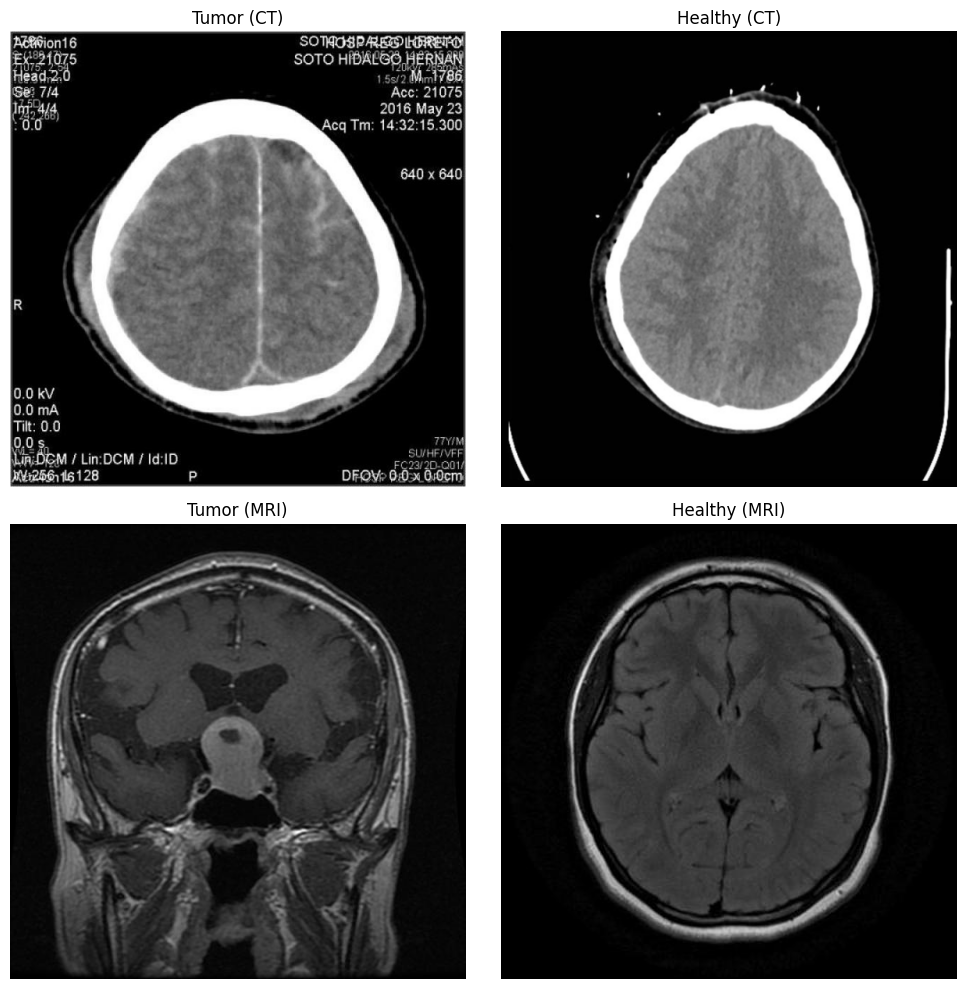

In [ ]:
ct_patient = next(item for item in data if item[1] == 'Tumor' and item[2] == 'CT')  # Tumor from CT
ct_healthy = next(item for item in data if item[1] == 'Healthy' and item[2] == 'CT')  # Healthy from CT
mri_patient = next(item for item in data if item[1] == 'Tumor' and item[2] == 'MRI')  # Tumor from MRI
mri_healthy = next(item for item in data if item[1] == 'Healthy' and item[2] == 'MRI')  # Healthy from MRI

# add iamges to list
selected_images = [ct_patient, ct_healthy, mri_patient, mri_healthy]

# show the images
plt.figure(figsize=(10, 10))

for i, (path, label, source) in enumerate(selected_images):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(f"{label} ({source})")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
image_paths = [item[0] for item in data]
labels = [item[1] for item in data]
sources = [item[2] for item in data]

# convert labels to numbers
label_map = {'Tumor': 1, 'Healthy': 0}
labels = np.array([label_map[label] for label in labels])

train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.3, random_state=42)

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

In [ ]:
val_datagen = ImageDataGenerator(rescale=1.0/255)

def generate_images(image_paths, labels, batch_size=32, target_size=(224, 224)):
    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]

            images = []
            for img_path in batch_paths:
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
                img = tf.keras.preprocessing.image.img_to_array(img)
                images.append(img)

            images = np.array(images)
            yield images, np.array(batch_labels)

train_generator = generate_images(train_paths, train_labels, batch_size=32)
val_generator = generate_images(val_paths, val_labels, batch_size=32)

In [ ]:
def generate_images(image_paths, labels, batch_size=32, target_size=(224, 224)):
    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]

            images = []
            for img_path in batch_paths:
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
                img = tf.keras.preprocessing.image.img_to_array(img)
                images.append(img)

            images = np.array(images)
            yield images, np.array(batch_labels)

train_generator = generate_images(train_paths, train_labels, batch_size=32)
val_generator = generate_images(val_paths, val_labels, batch_size=32)


In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#  Fine-Tuning
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # one output (tumor / healthy)

# bulid the model
model = Model(inputs=base_model.input, outputs=predictions)

# while training , trainable = false
for layer in base_model.layers:
    layer.trainable = False


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(
    train_generator,
    steps_per_epoch=len(train_paths) // 32,
    validation_data=val_generator,
    validation_steps=len(val_paths) // 32,
    epochs=10
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 2000s 9s/step - accuracy: 0.8482 - loss: 0.3612 - val_accuracy: 0.9444 - val_loss: 0.1378
Epoch 2/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 1928s 9s/step - accuracy: 0.9590 - loss: 0.1139 - val_accuracy: 0.9285 - val_loss: 0.1783
Epoch 3/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 1945s 9s/step - accuracy: 0.9637 - loss: 0.0925 - val_accuracy: 0.9544 - val_loss: 0.1269
Epoch 4/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 1941s 9s/step - accuracy: 0.9706 - loss: 0.0814 - val_accuracy: 0.9636 - val_loss: 0.0998
Epoch 5/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 1960s 9s/step - accuracy: 0.9696 - loss: 0.0754 - val_accuracy: 0.9527 - val_loss: 0.1625
Epoch 6/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 1930s 9s/step - accuracy: 0.9708 - loss: 0.0813 - val_accuracy: 0.9657 - val_loss: 0.1023
Epoch 7/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 1924s 9s/step - accuracy: 0.9840 - loss: 0.0431 - val_accuracy: 0.9741 - val_loss: 0.0767
Epoch 8/10
210/210 ━━━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
Prediction (sigmoid output): 8.08253898867406e-05
The model predicts: Healthy


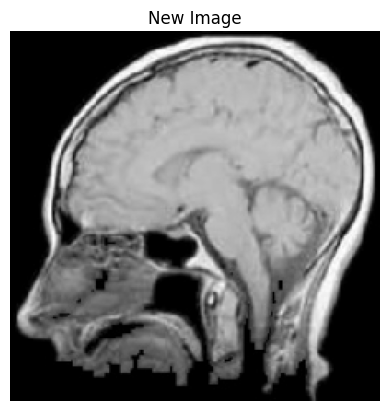

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
new_image_path = '/content/mri_healthy (995).jpg'


target_size = (224, 224)
img = load_img(new_image_path, target_size=target_size)
img_array = img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)


prediction = model.predict(img_array)
print(f"Prediction (sigmoid output): {prediction[0][0]}")

threshold = 0.0001
if prediction[0][0] > threshold:
    print("The model predicts: Tumor")
else:
    print("The model predicts: Healthy")


plt.imshow(img)
plt.title("New Image")
plt.axis("off")
plt.show()

In [ ]:
!pip install streamlit streamlit-aggrid pyngrok


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 813.6/813.6 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: altair
    Found existing installation: altair 5.5.0
    Uninstalling altair-5.5.0:
      Successfully uninstalled altair-5.5.0


In [ ]:
model.save("tumor_model.h5", save_format='h5')


In [ ]:
!ls



 brain-tumor-multimodal-image-ct-and-mri.zip   drive		        sample_data
'ct_tumor (1).png'			      'kaggle (1).json'         tumor_model.h5
'ct_tumor (4).png'			       kaggle.json
 Dataset				      'mri_healthy (995).jpg'


In [ ]:
model.save("tumor_model.keras")


In [ ]:
!ls

 brain-tumor-multimodal-image-ct-and-mri.zip   drive		        sample_data
'ct_tumor (1).png'			      'kaggle (1).json'         tumor_model.h5
'ct_tumor (4).png'			       kaggle.json	        tumor_model.keras
 Dataset				      'mri_healthy (995).jpg'


In [ ]:
model = tf.keras.models.load_model("tumor_model.keras")


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
!pip install streamlit pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.6 MB/s eta 0:00:00


In [ ]:
from pyngrok import ngrok

In [ ]:
!ngrok authtoken 2qx1MtBgkCO6HC75k3pDA461iKZ_3drHqWVdyLEWxrKohbTNS

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok

# Set up a tunnel to the streamlit app
public_url = ngrok.connect(8501)
print('Streamlit app is live at:', public_url)

Streamlit app is live at: NgrokTunnel: "https://3262-35-188-237-0.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
!streamlit run app.py

Usage: streamlit run [OPTIONS] TARGET [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: app.py


In [ ]:
import streamlit as st
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import cv2
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image


model = tf.keras.models.load_model("tumor_model.h5")


def generate_gradcam_heatmap(model, img_array, last_conv_layer_name="conv5_block3_out"):
    grad_model = tf.keras.models.Model(
        [model.input],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1
    return heatmap


def predict_and_visualize(image):
    img_array = img_to_array(image) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    label = "Tumor" if prediction[0] > 0.5 else "Healthy"
    confidence = prediction[0][0]


    heatmap = generate_gradcam_heatmap(model, img_array)
    heatmap_resized = cv2.resize(heatmap, (image.size[0], image.size[1]))
    heatmap_overlay = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    overlay_image = cv2.addWeighted(
        cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR), 0.6, heatmap_overlay, 0.4, 0
    )

    return label, confidence, overlay_image


st.title("Brain Tumor Prediction")
st.write("Upload an image to predict if it contains a brain tumor.")

uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file).resize((224, 224))
    label, confidence, overlay_image = predict_and_visualize(image)

    st.image(image, caption="Uploaded Image", use_column_width=True)
    st.write(f"Prediction: **{label}**")
    st.write(f"Confidence: **{confidence:.2f}**")

    st.write("Grad-CAM Heatmap:")
    st.image(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB), use_column_width=True)
